In [1]:
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
from tqdm.auto import tqdm
import pingouin as pg

In [2]:
def create_delta_df(df_in, activity_column ='pIC50', method = "concat"):
    merge_df = pd.merge(df_in,df_in,how='cross')
    merge_df['delta'] = merge_df[activity_column+"_x"] - merge_df[activity_column+"_y"]
    if method == "subtract":
        merge_df['combo_fp'] = [a-b for a,b in merge_df[["fp_x","fp_y"]].values]
    elif method == 'concat':
        merge_df['combo_fp'] = [np.concatenate([a,b]) for a,b in merge_df[["fp_x","fp_y"]].values]
    else:
        assert(False)
    return merge_df

In [3]:
def run_test(df_in, num_cycles, model=LGBMRegressor):
    calc = FPCalculator("ecfp")
    trans = MoleculeTransformer(calc)
    df_in['fp'] = trans.transform(df_in.SMILES.values)
    output_list = []
    for i in tqdm(range(0,num_cycles)):
        train, test = train_test_split(df_in)
        
        single_model = model(n_jobs=-1)
        single_model.fit(np.stack(train.fp),train.pIC50)
        single_pred = single_model.predict(np.stack(test.fp))
        tmp_df = test.copy()
        tmp_df['pred'] = single_pred
        tmp_merge_df = create_delta_df(tmp_df)
        tmp_merge_df['pred_delta'] = tmp_merge_df.pred_x - tmp_merge_df.pred_y
        r2_single = r2_score(tmp_merge_df.delta, tmp_merge_df.pred_delta)
        rmse_single = mean_squared_error(tmp_merge_df.delta, tmp_merge_df.pred_delta, squared=False)

        
        train_delta_df = create_delta_df(train, method='concat')
        test_delta_df = create_delta_df(test, method='concat')
        delta_model = model(n_jobs=-1)
        delta_model.fit(np.stack(train_delta_df.combo_fp), train_delta_df.delta)
        delta_pred = delta_model.predict(np.stack(test_delta_df.combo_fp))
        r2_delta = r2_score(test_delta_df.delta, delta_pred)
        rmse_delta = mean_squared_error(test_delta_df.delta, delta_pred, squared=False)

        output_list.append([i, r2_single, r2_delta, rmse_single, rmse_delta])
    return output_list

In [4]:
def process_file(filename):
    df = pd.read_csv(filename,sep=" ",names=["SMILES","Name","pIC50"])
    res = run_test(df,10)
    res_df = pd.DataFrame(res,columns=["cycle","r2_single","r2_delta","rmse_single","rmse_delta"])
    res_df['filename'] = filename
    return res_df

In [13]:
res_df = process_file("data/COX-2.smi")

  0%|          | 0/10 [00:00<?, ?it/s]

MemoryError: Unable to allocate 62.8 GiB for an array with shape (16845963264,) and data type float32

In [10]:
melt_df = pd.melt(res_df[["cycle","r2_single","r2_delta"]],id_vars="cycle")
melt_df.columns=["cycle","method","r2"]
melt_df.head()

,cycle,method,r2
0,0,r2_single,0.762825
1,1,r2_single,0.762723
2,2,r2_single,0.770601
3,3,r2_single,0.770780
4,4,r2_single,0.785416


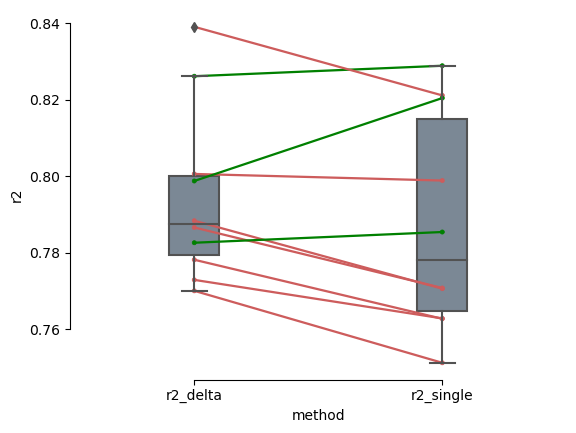

In [11]:
ax = pg.plot_paired(data=melt_df, dv='r2', within='method', subject='cycle')

In [12]:
r2_delta = res_df.r2_single.values-res_df.r2_delta.values
d = abs(np.mean(r2_delta)/np.std(r2_delta))
prob_d = 0.25 * d + 0.5 
d,prob_d

(0.5605227729029337, 0.6401306932257335)